# Numerical optimization

Rather than using analytical methods to solve the portfolio optimization problem, we can use an algorithm to find the solution numerically.

We'll begin by reading in the same returns data we used in the previous section.

In [5]:
rets = pd.read_csv('https://raw.githubusercontent.com/stoffprof/qf/main/data/MSCI_returns.csv',
                   index_col='date', parse_dates=['date'])

The calculation below shows that, across our 33 countries, the average monthly return is 0.60%, or 60 basis points.

In [8]:
rets.mean().describe()

count    33.000000
mean      0.005987
std       0.003179
min       0.001083
25%       0.003382
50%       0.005219
75%       0.007208
max       0.014904
dtype: float64

When working with numerical optimization algorithms, it is important that the values being used in a function are not too small. If they are, the rounding error in calculations may be nonneglible relative to the magnitude of the values in the function, and the error can start to swamp the actual information.

An easy solution in these data is simply to multiply by 100, which converts the units to percentage points.

In [12]:
# convert returns to percent
rets = rets * 100

In [14]:
# store parameter estimates in numpy arrays

μ = rets.mean().values
Σ = rets.cov().values
N = len(μ)

In [16]:
# Create an equal-weights vector of N elements
ewgts = np.repeat(1/N, N)

In [18]:
def mvs(weights):
    '''Calculate mean, volatility, and Sharpe Ratio for a given set of portfolio weights'''
    μp = weights.T @ μ
    σp = np.sqrt(weights.T @ Σ @ weights)
    return μp, σp, μp/σp

The equal-weighted portfolio has a return of 0.6%, volatility of about 5.3%, and a Sharpe ratio of 0.11:

In [21]:
mvs(ewgts)

(0.5987296508261588, 5.254623942806401, 0.1139433872610088)

To implement numerical optimization, we start as before with the minimization problem:

\begin{equation*}
\begin{aligned}
\min_{\omega} \quad & \boldsymbol{\omega}'\boldsymbol{\Sigma}\boldsymbol{\omega} \\
\textrm{subject to} \quad & \boldsymbol{\omega}'\boldsymbol{\mu} = \mu_p\\
  &\boldsymbol{\omega}'\mathbf{1} = 1.
\end{aligned}
\end{equation*}

Suppose we want an efficient portfolio with an expected return of 1.2% (per month). Then the *target return* is

$$\mu_p = 1.2.$$

In [23]:
# target return
tret = 1.2

We can use the minimization algorithms in `scipy` to find us an efficient portoflio (that is, the one that achieves the target return and has minimum variance). To do so, we need to pass the function we want to minimize and the constraints.

In [26]:
import scipy.optimize as sco

Each constraint is entered as dictionary. Since we have two constraints, we'll pass a list of two dictionaries. Each dictionary has two keys: `type` indicating whether it is an equality or inequality constraint; and `fun` that encodes a function representing the constraint. The function must return zero when the constraint is satisfied.

In [29]:
cons = [
    # expected return equals target return
    {'type': 'eq', 'fun': lambda w:  mvs(w)[0] - tret},  
    
    # weights sum to one
    {'type': 'eq', 'fun': lambda w:  np.sum(w) - 1}
]

Next, we'll define a function that gives the variance of a portfolio given its weights.

In [32]:
def portvar(weights):
    return mvs(weights)[1]**2

We're ready to call the optimization algorithm. We just pass the function to minimize, a starting point for the algorithm (a set of initial weights), and the name of the algorithm we want to use.

In [35]:
p = sco.minimize(portvar,             # function to minimize
                 ewgts,               # starting point for variables (weights)
                 constraints = cons,  # constraints
                 method = 'SLSQP'     # minimization algorithm (sequential quadratic programming)
                 )  

The result from calling the minizer is a `scipy` object that contains information about the solution.

In [38]:
p

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 15.751368675928148
       x: [ 5.147e-03  9.919e-02 ... -5.111e-02  8.972e-01]
     nit: 40
     jac: [ 3.554e+01  2.205e+01 ...  1.942e+01  2.516e+01]
    nfev: 1419
    njev: 40

We see the value of the function at its minimum, `fun`. In our case, this is the value of the minimized variance. The `message` indicates that the optimization algorithm worked.

The minimization algorithm returns the $x$ values for the minimized function—in this case, the weights of the efficient portfolio—in the `x` property of the results object. We can pass that to our `mvs()` function to get the expected return, variance, and Sharpe ratio of this portfolio.

In [40]:
mvs(p['x'])

(1.1999999999908963, 3.9687993998094875, 0.30235844120730804)

Not surprisingly, the expected return of the portfolio is 1.2%; it should be, since one of the constraints we passed the optimizer was that this was the target return. The volatility is {glue:}`portvol`, which matches the square-root of the variance.

We can compare this value to the analytical result from equation {eq}`eff_var`:

In [46]:
from numpy.linalg import inv

Σinv = inv(Σ)
A = μ.T @ Σinv @ μ
B = μ.T @ Σinv @ np.ones(N)
C = np.ones(N).T @ Σinv @ np.ones(N)

# variance equation
(C * tret**2 - 2*B*tret + A) / (A*C - B**2)

15.751368557754242

This value from the analytical solution is almost identical to the variance calculated with `scipy` above.

We can also compare the weights from the analytical solution to those found by `scipy`.

In [49]:
# weights of efficient portfolio using analytical solution

wgts_analytical = Σinv @ ((C*tret-B)*μ + (A-B*tret)*np.ones(N)) / (A*C-B**2)

wgts_analytical

array([ 0.00514628,  0.09920569, -0.13655024, -0.00909096, -0.14301062,
        0.1189983 ,  0.52594177, -0.00794929,  0.13022454, -0.3051789 ,
       -0.0534784 ,  0.07247556, -0.00486355, -0.16409209, -0.00335494,
       -0.00171409, -0.02500287,  0.08706908,  0.04798438, -0.07742041,
       -0.0414416 , -0.12018641, -0.01128564, -0.09122505, -0.14088947,
        0.01444873, -0.15044581,  0.51636976,  0.03909081, -0.0512624 ,
        0.03542919, -0.05111529,  0.89717394])

In [53]:
# Difference between analytical weights and scipy weights
wgts_analytical - p['x']

array([-8.31800525e-07,  1.72201534e-05,  7.58057903e-05,  6.69073618e-07,
       -7.21419571e-06,  1.13523784e-06,  2.31820235e-05,  9.59651024e-06,
       -6.76200951e-05, -4.61834453e-05, -1.20893138e-06, -4.88056858e-06,
       -2.46758868e-06, -1.59898413e-05, -3.92145323e-06,  1.97741864e-06,
       -2.43220396e-06,  5.79067308e-06, -4.16024493e-06,  4.10699853e-05,
       -5.34112173e-06, -2.28023537e-05, -1.31889907e-06, -6.36107380e-06,
        9.83375003e-06,  3.54558344e-05,  9.79279727e-06, -4.29818151e-05,
        3.91137599e-06, -3.72928379e-06, -3.48646804e-07, -5.54178045e-06,
        9.89471954e-06])

Clearly, the efficient portfolios found by each method are essentially the same.

## The efficient frontier

To find the efficient frontier, we can sweep across values of $\mu_p$, and for each one find the portfolio with minimum variance.

In [58]:
# target returns
trets = np.linspace(-1, 3, 50)

In [60]:
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda w:  mvs(w)[0] - tret},
            {'type': 'eq', 'fun': lambda w:  np.sum(w) - 1})
    res = sco.minimize(portvar, ewgts, method='SLSQP', constraints=cons)
    tvol = np.sqrt(res['fun'])
    tvols.append(tvol)

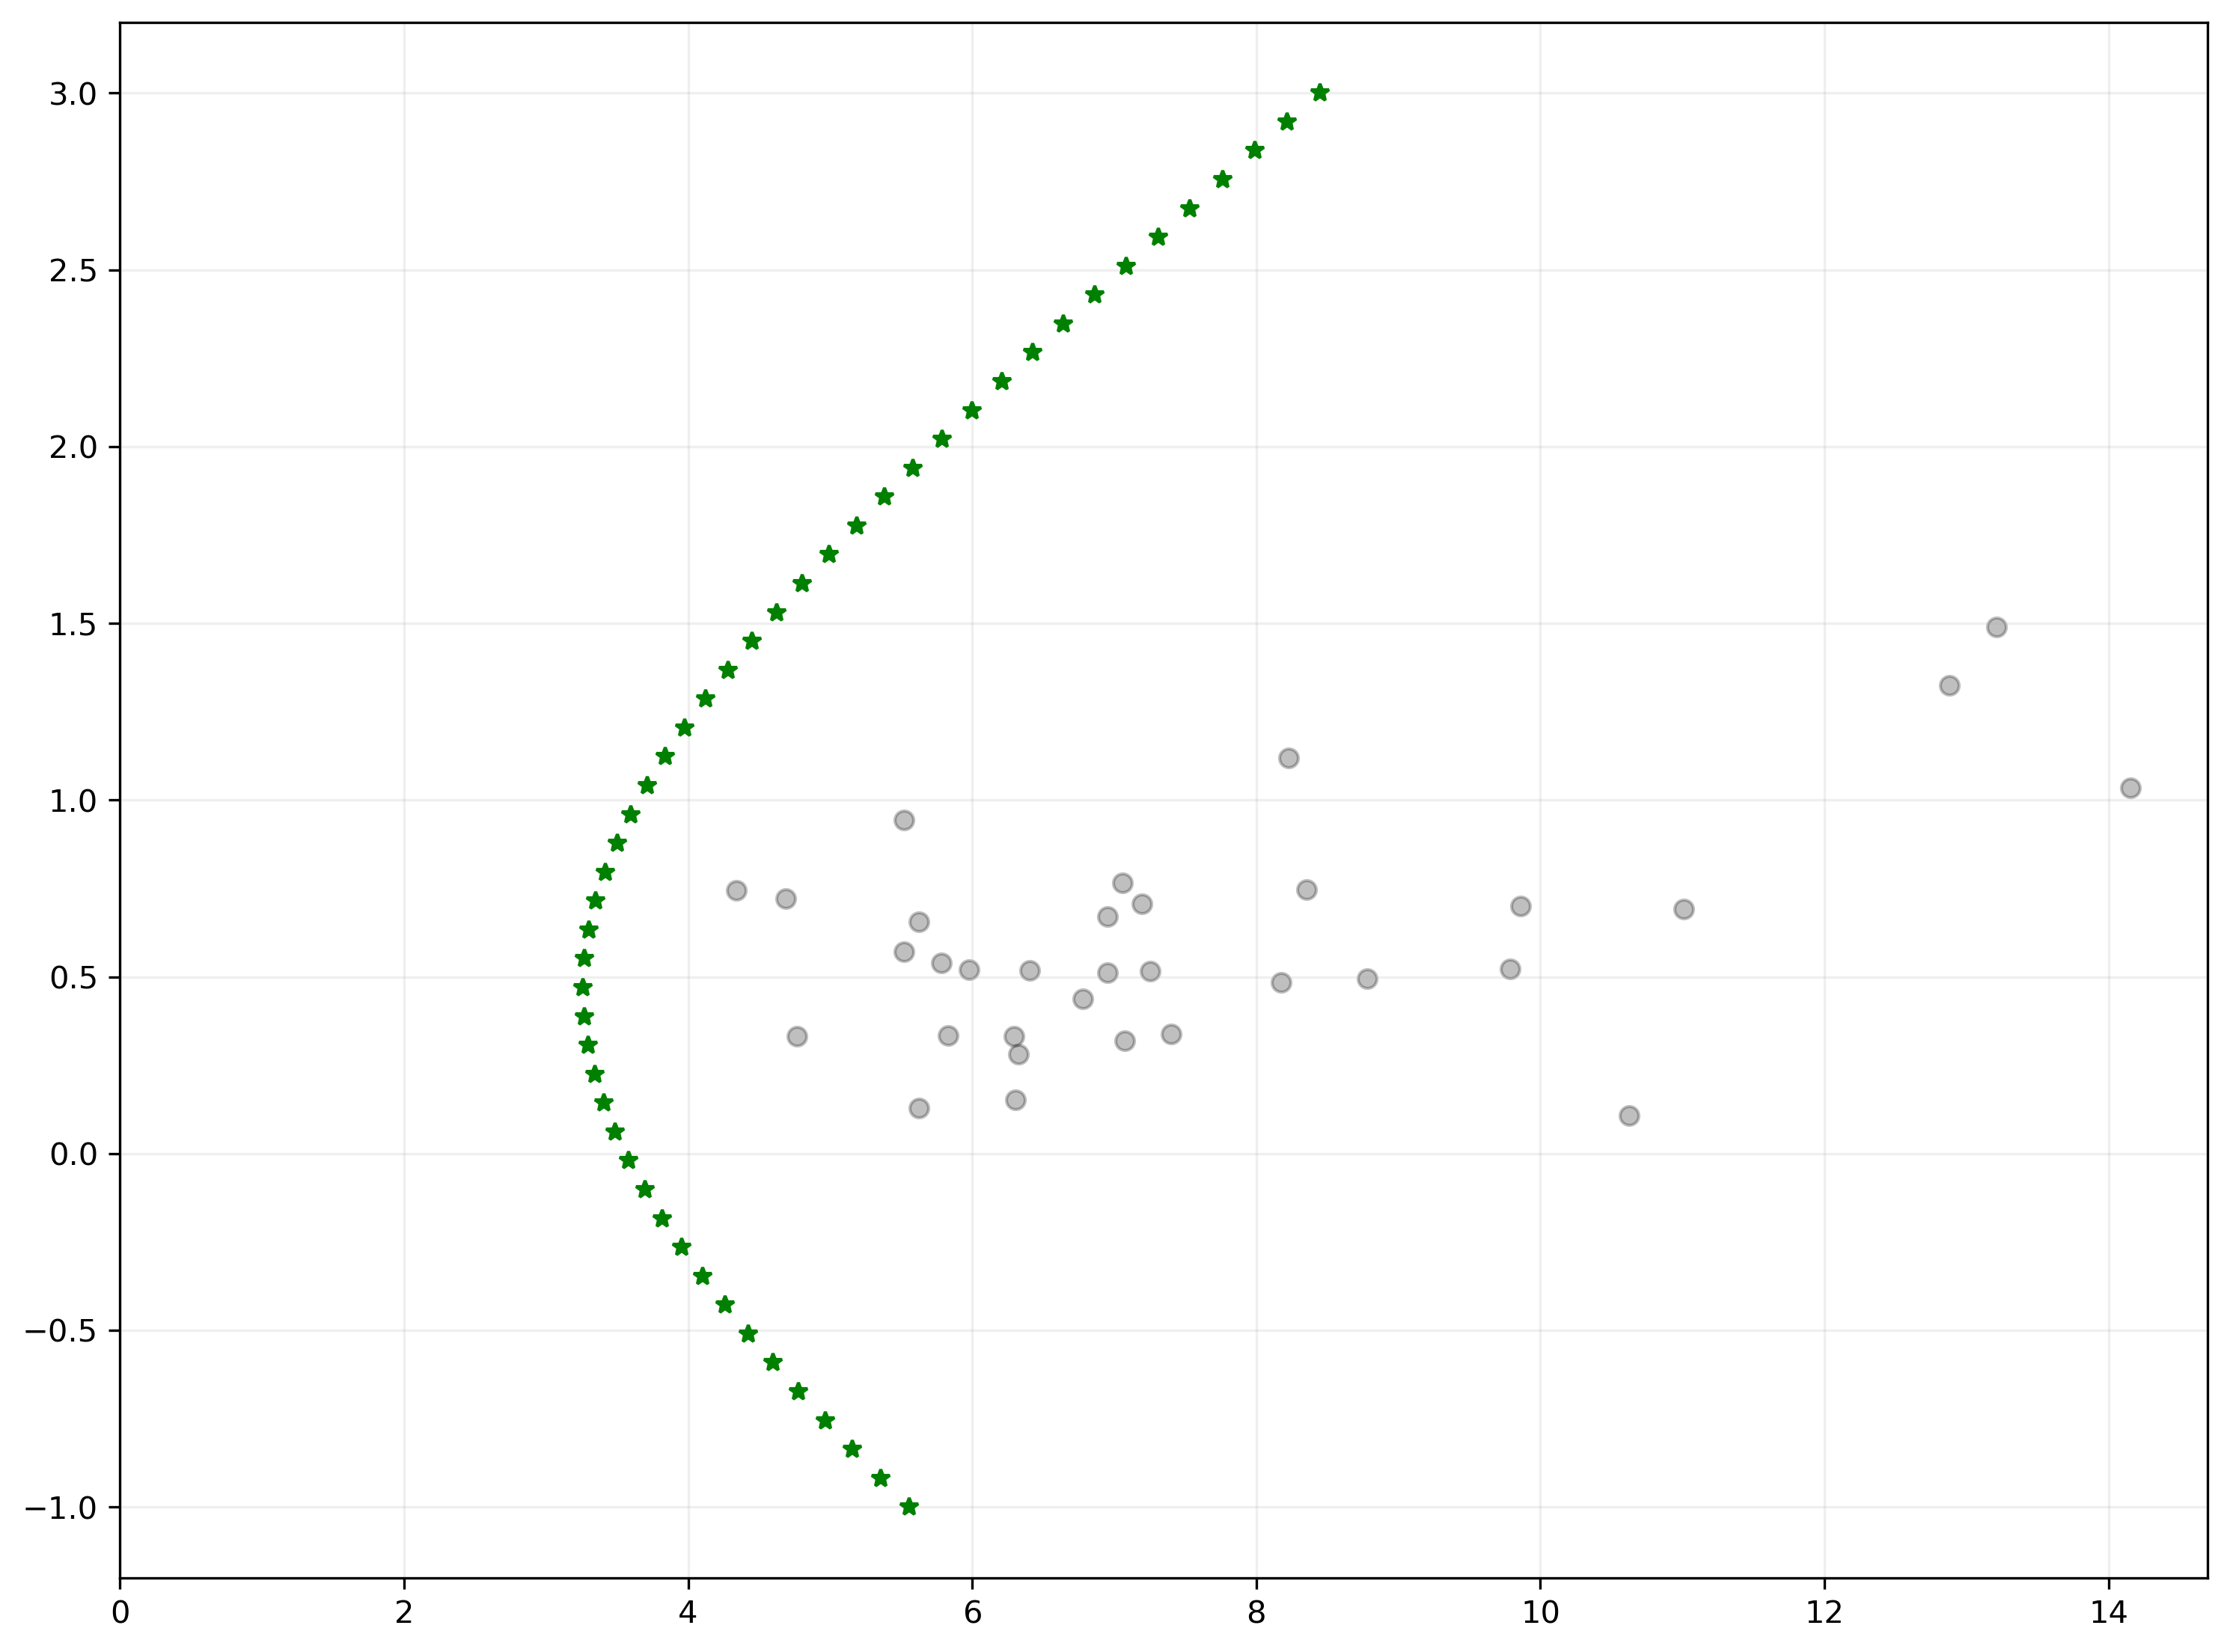

In [61]:
fig, ax = plt.subplots()

# initial portfolios
for i in range(N):
    plt.scatter(np.sqrt(Σ[i,i]), μ[i], color='k', alpha=0.25)
    
# Efficient frontier
ax.plot(tvols, trets, 'g*')

# xmax = np.sqrt(np.diag(Σ)).max() * 1.1
# ymax = μ.max() * 1.1
ax.set_xlim(0, None)
ax.grid(alpha=0.2)
plt.show()

### The GMV portfolio

Analytically, we found the GMV by minimizing the function for the variance of an efficient portfolio. We set the derivative equal to zero, and solved.

Working numerically, we accomplish the same thing by specifying a new problem, although without a constraint to achieve any particular target return. That is, the problem is simply to find the minimum variance of *any* feasible portfolio, regardless of its expected return.

\begin{equation*}
\begin{aligned}
\min_{\omega} \quad & \boldsymbol{\omega}'\boldsymbol{\Sigma}\boldsymbol{\omega} \\
\textrm{subject to} \quad & \boldsymbol{\omega}'\mathbf{1} = 1.
\end{aligned}
\end{equation*}

To implement this, all we have to do is redefine the constraint:

In [67]:
cons_gmv = {'type': 'eq',
            'fun': lambda w: np.sum(w) - 1}

gmv = sco.minimize(portvar, ewgts, constraints=cons_gmv, method='SLSQP')

In [69]:
gmv

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 10.62621981626728
       x: [-1.596e-02  4.487e-02 ...  3.169e-01  6.821e-01]
     nit: 35
     jac: [ 2.125e+01  2.125e+01 ...  2.125e+01  2.125e+01]
    nfev: 1246
    njev: 35

In [71]:
mvs(gmv['x'])

(0.4634100699342624, 3.2597883085052133, 0.14215955947972606)

### The tangency portfolio

We previously saw that the Tangency portfolio has the maximum possible Sharpe ratio of any portfolio. The problem is therefore

\begin{equation*}
\begin{aligned}
\max_{\omega} \quad & \frac{\boldsymbol{\omega}'\boldsymbol{\mu}}{\sqrt{\boldsymbol{\omega}'\boldsymbol{\Sigma}\boldsymbol{\omega}}}\\
\textrm{subject to} \quad & \boldsymbol{\omega}'\mathbf{1} = 1.
\end{aligned}
\end{equation*}

The only complication is that `scipy` provides a method to minimize a function, but not maximize one. Not to worry: if we simply multiply our function by minus one and find the maximum, we will have found the minimum of the original function. (Maximizing $f(x) = -x^2$ is the same as minimizing $f(x) = x^2$. Either way the answer is $x=0$.)

In [75]:
def neg_sharpe(weights):
    return -mvs(weights)[2]

In [77]:
tng = sco.minimize(neg_sharpe, ewgts,
                   constraints=cons_gmv,  # note same constraints as GMV
                   method='SLSQP')

In [79]:
tng

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.35505930463989627
       x: [ 5.379e-02  2.246e-01 ... -8.988e-01  1.397e+00]
     nit: 40
     jac: [-2.654e-04 -2.005e-04 ... -2.167e-04 -8.932e-05]
    nfev: 1360
    njev: 40

In [81]:
mvs(tng['x'])

(2.894257512594097, 8.151476316131115, 0.35505930463989627)

The Sharpe ratio of the tangency portfolio is about {glue:}`sr_ratio` times that of the GMV portfolio.

## Changing the constraints

So far, we used the minimization algorithm to get an answer that we already know how to find using analytical methods. So what is the benefit of using a numerical solver?

Numerical solutions can be found for problems that are much harder or even impossible to solve with analytical techniques.

### Short-sale constraints

For example, many investors, including mutual funds, cannot engage in short selling. That is, they cannot hold a negative position in any asset.

We can represent their problem by adding one additional set of constraints to the problem that requires that all values of $\omega$ must be nonnegative.

\begin{equation*}
\begin{aligned}
\min_{\omega} \quad & \boldsymbol{\omega}'\boldsymbol{\Sigma}\boldsymbol{\omega} \\
\textrm{subjct to} \quad & \boldsymbol{\omega}'\boldsymbol{\mu} = \mu_p,\\
  &\boldsymbol{\omega}'\mathbf{1} = 1, \\
  &\omega_i\geq 0 \quad \forall i.
\end{aligned}
\end{equation*}

This problem is *much* harder to solve analytically, but trivial for the `scipy` algorithm. We simply add additional constraints to the problem.

The constraint that $\omega_i > 0$ is actually a special type of constraint called a *boundary*. These are easiest to implement by passing a list of upper- and lower-bounds to the algorithm.

In [91]:
bounds = [(0, 1) for w in range(N)]

With a long-only portfolio there is no way to construct a portfolio with a return that is less than that of the lowest-return asset, or above that of the highest-return asset, so we have to choose a target return in that range.

In [94]:
tret = 1.2

In [96]:
assert tret<max(μ), 'Target return is infeasible'

In [98]:
cons = [
    # expected return equals target return
    {'type': 'eq', 'fun': lambda w:  mvs(w)[0] - tret},  
    
    # weights sum to one
    {'type': 'eq', 'fun': lambda w:  np.sum(w) - 1}
]

In [100]:
p2 = sco.minimize(portvar, ewgts, constraints=cons, bounds=bounds, method='SLSQP')

In [102]:
p2['message']

'Optimization terminated successfully'

In [104]:
p2['x']

array([3.01767497e-01, 7.31804815e-14, 8.17230300e-14, 1.54517084e-01,
       2.58107029e-13, 2.38041232e-13, 3.57540165e-01, 4.96449418e-13,
       3.38801232e-14, 6.35706029e-13, 3.96096973e-12, 6.43955974e-14,
       1.91318546e-12, 1.19463344e-13, 1.12925565e-12, 5.94091899e-13,
       1.31009525e-12, 2.31568346e-13, 1.86175254e-01, 1.97475692e-13,
       1.71193196e-13, 1.47474950e-12, 1.91893158e-14, 1.05296253e-13,
       9.17307378e-13, 1.23903023e-12, 6.94355773e-13, 8.26008434e-13,
       3.26620137e-13, 2.34128808e-12, 2.82078115e-12, 4.09812152e-13,
       8.11470150e-13])

The portfolio has the desired expected return of 6%, volatility of about 14%, and a Sharpe ratio of 0.43.

In [107]:
mvs(p2['x'])

(1.2000000007879021, 7.176131185216429, 0.16722102339210662)

:::{admonition} Check your understanding
:class: tip

The Sharpe ratio of this minimum-variance portfolio is significantly less than what we found above when we didn't impose short-sale constraints. Why?
:::

Many of the weight in the portfolio are now zero:

In [111]:
w = pd.Series(p2['x'], index=rets.columns)

w[w>0.0001].sort_values(ascending=False)

Denmark      0.357540
Argentina    0.301767
Mexico       0.186175
Brazil       0.154517
dtype: float64

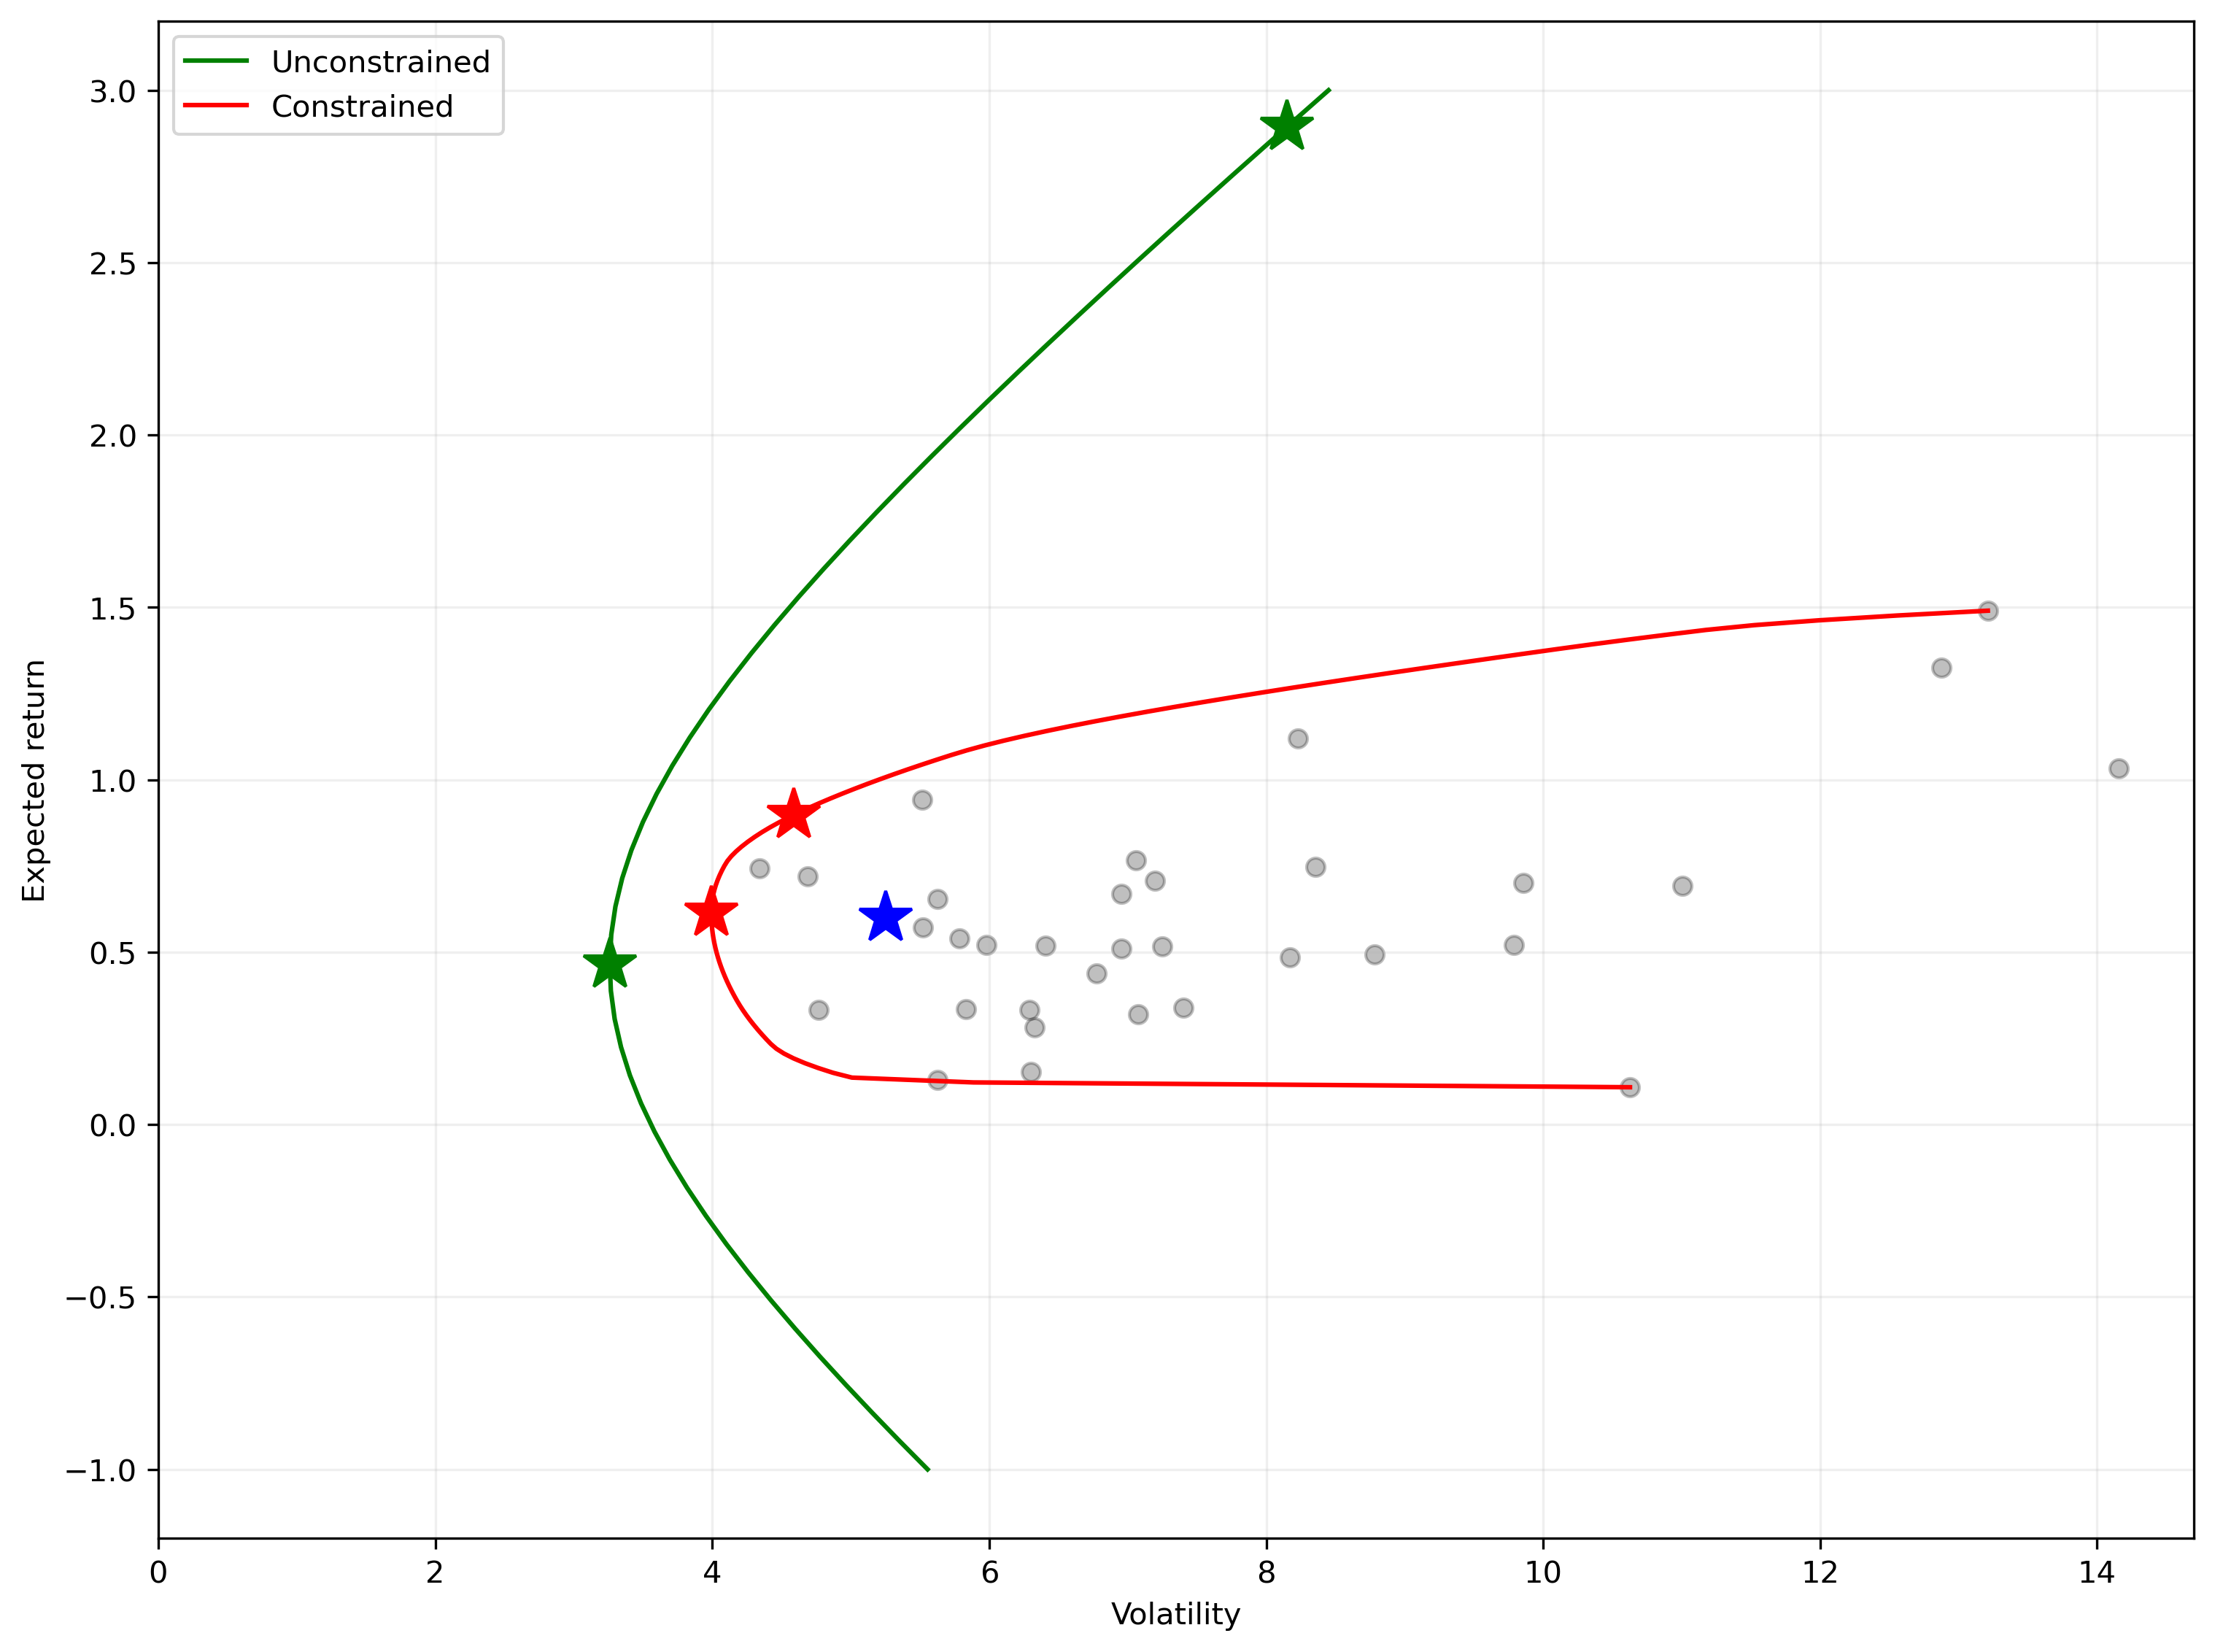

In [115]:
fig, ax = plt.subplots()

# initial portfolios
for i in range(N):
    plt.scatter(np.sqrt(Σ[i,i]), μ[i], color='k', alpha=0.25)
    
# EW portfolio
m,v,_ = mvs(ewgts)
ax.plot(v, m, 'b*', markersize=18)

################################################################
# Unconstrained
################################################################

# Efficient frontier
ax.plot(tvols, trets, 'g', label='Unconstrained')

# GMV
m,v,_ = mvs(gmv['x'])
ax.plot(v, m, 'g*', markersize=18)

# Tangency
m,v,_ = mvs(tng['x'])
ax.plot(v, m, 'g*', markersize=18)

################################################################
# Long-only portfolios
################################################################

# Efficient frontier
tvols_c = []
trets_c = np.linspace(μ.min(), μ.max(), 100)
for tret in trets_c:
    cons = ({'type': 'eq', 'fun': lambda w:  mvs(w)[0] - tret},
            {'type': 'eq', 'fun': lambda w:  np.sum(w) - 1})
    res = sco.minimize(portvar, ewgts, constraints=cons, bounds=bounds, method='SLSQP')
    tvol = np.sqrt(res['fun'])
    tvols_c.append(tvol)

ax.plot(tvols_c, trets_c, 'r', label='Constrained')

# GMV
gmv_c = sco.minimize(portvar, ewgts, constraints=cons_gmv, bounds=bounds, method='SLSQP')
m,v,_ = mvs(gmv_c['x'])
ax.plot(v, m, 'r*', markersize=18)

# Tangency
tng_c = sco.minimize(neg_sharpe, ewgts, constraints=cons_gmv, bounds=bounds, method='SLSQP')
m,v,_ = mvs(tng_c['x'])
ax.plot(v, m, 'r*', markersize=18)


ax.set_xlabel('Volatility')
ax.set_ylabel('Expected return')

ax.set_xlim(0, None)
ax.legend(loc='upper left')
ax.grid(alpha=0.2)
plt.show()

:::{admonition} Exercise
:class: exercise

Suppose a hedge fund can use leverage (that is, borrow money) to buy stocks. This leverage allows the fund to have 200% of its capital invested in its portfolio.  Also, it can short stocks, but only up to a weight of –20% in each stock; similarly it cannot have a weight of more than +50% in any stock. What are the expected return, volatility, and Sharpe ratio of its this fund's tangency portfoio?

:::

## Variations

There are numerous ways that we might want to constrain the optimization problem:

- We might want a *sparse* solution, where we only select a small number of assets to hold.
- Alternatively, we might want to require a certain number of assets in the portfolio, or a minimum holding in every asset.
- We could add a cost of shorting.
- We could include *transaction costs* that reflect the cost of adjusting our portfolio from its current holdings. An often-used model if transaction cost is, for a given trade size $x$,

$$C(x) = a|x| + b\sigma \frac{|x|^{3/2}}{V^{3/2}} + cx,$$

where $a$, $b$, and $c$ are parameters, $\sigma$ is volatility, and $V$ is the volume of trading in the asset. $a$ reflects the bid–ask spread. See, for example, [Boyd et al. (2017).](http://dx.doi.org/10.1561/2400000023)

## Utility maximization

<img src="https://host.kelley.iu.edu/nstoffma/da/MV-utility.gif">
Source: Ang (2014), Figure 3.8